In [75]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as pl
from scipy.optimize import least_squares
from datetime import date, timedelta
import numba
import random
import math


# Importando dados

In [76]:
# Dados começam 01/01/2022
# Vacinação começa 19/01/2022
# fillna(0) substitui todos os valores sem input por 0
Dados= pd.read_csv ('../dados_usados/Dados_novos_BAHIA.csv')
vacinados_dados = Dados['Vacinados'].fillna(0)
mortos_dados = Dados['Mortos'].fillna(0)
casos_dados = Dados['Casos acumulados'].fillna(0)
datas = Dados["datetime"].fillna(0)

# Removendo diffs menores que 0 na vacinação

In [77]:
vacinados_dados_aux =  np.copy(vacinados_dados)
# Diffs menores que 0 serão substituidos pela repetição do valor anterior, tornando todo valor igual ou maior que o anterior
for i in range(1,len(vacinados_dados_aux)):
    diff = vacinados_dados_aux[i] - vacinados_dados_aux[i-1]
    if diff < 0:
        vacinados_dados_aux[i-1] = vacinados_dados_aux[i]

novos_vacinados =  np.diff(vacinados_dados_aux)
novos_vacinados = novos_vacinados.tolist()
novos_vacinados.insert(0, 0)

# Parametros do modelo

In [78]:
# Ultima revisão: 05/01/2023
k = 1/4
gamma_a = 1/3.5
gamma_s = 1/4
gamma_h = 0.18
gamma_u = 0.13
mi_u = 0.4
qsi = 0.53 
h = 0.06
h_v = 0.012
mi_h = 0.15
ome_h = 0.14
ome_u = 0.29
delta = 0.31
p = 0.2
    
delta_av = 0.31
delta_sv = 0.31
phi_e = 0.7
k_v=1/3
p_v = 0.1
gamma_av = 1/3.5
gamma_sv = 1/4
gamma_vu=0.26
qsi_v = 0.99
eps=0.7
mi_vh=0.03
mi_vu=0.08
gamma_vh=0.36


# Modelo

In [79]:
def SEIIHURD(y,t, args):

    beta0, beta1, beta2,beta3, t1, t2,t3 = args

    if t<t1:
        beta=beta0    
    elif (t>=t1):
        beta=beta1
    elif (t>=t2):
        beta=beta2
    elif t>=t3:
        beta=beta3

    beta_v = beta/2
    
    tau = novos_vacinados[int(t)]

    N=14873064
    
    psi= 0.5  #Psif[int(t)]
    S=y[0]
    E=y[1]
    V=y[2]
    Sv=y[3]
    Ev=y[4]
    Ia=y[5]
    Is=y[6]
    Iav=y[7]
    Isv=y[8]
    H=y[9]
    Hv=y[10]
    U=y[11]
    Uv=y[12]
    R=y[13]
    Rv=y[14]
    D=y[15]
    Nw=y[16]
    NwV=y[17]

    dSdt = (-(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - tau/N
    dEdt = ((1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k*E
    dVdt = tau/N - phi_e*V - ((1-psi)*beta*V*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv))
    dSvdt =  phi_e*(1-eps)*V - ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) #- phi_e*eps*Sv
    dEvdt = ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k_v*Ev
    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv   
    dHdt = h*qsi*gamma_s*Is + (1-mi_u+ome_u*mi_u)*gamma_u*U - gamma_h*H   
    dHvdt = h_v*qsi_v*gamma_sv*Isv + (1-mi_vu+ome_u*mi_vu)*gamma_vu*Uv - gamma_vh*Hv    
    dUdt = h*(1-qsi)*gamma_s*Is + ome_h*gamma_h*H - gamma_u*U
    dUvdt = h_v*(1-qsi_v)*gamma_sv*Isv + ome_h*gamma_vh*Hv - gamma_u*Uv
    dRdt = gamma_a*Ia + (1-h)*gamma_s*Is + (1-mi_h)*(1-ome_h)*gamma_h*H
    dRvdt = gamma_av*Iav + (1-h_v)*gamma_sv*Isv + (1-mi_vh)*(1-ome_h)*(gamma_vh*Hv) + phi_e*eps*V
    dDdt = (1-ome_h)*(mi_h*gamma_h*H +mi_vh*gamma_vh*Hv) + (1-ome_u)*(mi_u*gamma_u*U+mi_vu*gamma_vu*Uv)
    dNwdt = p*k*E + p_v*k_v*Ev
    dNwVdt = tau/N
        
    return [dSdt, dEdt, dVdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dHvdt, dUdt, dUvdt, dRdt, 
            dRvdt, dDdt, dNwdt, dNwVdt]


In [80]:

def lq_SIR(pars, data, ts0, q0):

    beta0, beta1, beta2,beta3, t1, t2, t3 = pars
    #parameters
    parode = beta0, beta1, beta2,beta3, t1, t2,t3
    #calls integrator

    qs = odeint(SEIIHURD, q0, ts0, args=(parode,),mxstep=1000000)
    mortos = np.diff(qs[:,-3]*14930634)
    casos = np.diff(qs[:, -2]*14930634)
    #define the standardized residuals
    errMortos = (mortos - data) / np.sqrt(mortos+1)
    errCasos = (casos - np.diff(casos_dados))/np.sqrt(casos+1)
    return np.r_[(errMortos+errCasos)/2] 
    # return np.r_[errMortos]


In [81]:
def Best_Fit(data,n_tries, ts0, q0):

    # #DEEFINE THE INTERVALS OF PARS[0, 2.],[0, 2.], [0, 5.], [0, 5.],[0, 5.],[0, 80], [80, 170], [170, 240], [240, 400]
    intervals = np.array([[0, 5.],[0, 5.], [0, 5.], [0, 5.], [0, 160], [160, 260], [260, 300]])

    #NUMBER OF FITS
    #best error starts at inft 
    best_err = np.inf
    #aj the number of best fists 
    aj = 0
    for i in range(n_tries):
        if i%5 == 0:
            print(i)
            
        #create a set of parameters in the interval
        par0 = np.random.rand(len(intervals))
        par0 = intervals[:,0] + par0 * (intervals[:,1] - intervals[:,0])
        try:
            res = least_squares(lambda pars: lq_SIR(pars,data, ts0, q0), par0, bounds=(intervals[:,0], \
                                                intervals[:,1]))

            ier = res.status
            #if converges
            if ier >= 1 and ier <= 4:
                if res.cost < best_err:
                    #best_err = erro
                    best_err = res.cost
                    #best_pop = parametro
                    best_pop = res.x
                    #+1 best fit
                    aj = aj +1
                    print('achou',aj)
        except Exception as exp:
            print(exp)
            pass
                #in does not converge, do nothing

    return best_pop

In [82]:
N=14873064
#Posso adicionar 12.515 pessoas por dia
#initial conditions
q0 = [
    0.8002151436282163 ,
    0.0023662791892471815,
    0,
    0,
    0,
    0.0015491725384642486,
    0.0004385474858925033,
    0,
    0,
    3.0058880370174367e-05,
    0.0,
    2.5542546092586197e-05,
    0.0,
    0.15650499264821266,
    0,
    9159/N,
    (494684)/N,
    0
]

#Run the minimizer
n_tries=100  #Quanto maior mais certeza do resultado. Colocar em 100 para roda com mais certeza (Ou até maiws se for necessário)
ts0 =  np.arange(len(novos_vacinados))
#best_pop=Best_Fit(np.diff(mortos_dados), n_tries, ts0, q0)

#beta0, beta1, beta2, beta3, t1, t2, t3 = best_pop

#Create an x axixis for plotting the function.
#parameters
#parode = [beta0, beta1, beta2, beta3, t1, t2, t3]

# TEMPO FOI OTIMIZADO TAMBÉM 
parode = [1.90221545,   3.76585085,   2.14629225,   3.27760444,
         126.48480189, 172.97799643, 288.57269974]
# calls integrator

qs = odeint(SEIIHURD, q0, ts0, args=(parode,), mxstep=1000000)

0
achou 1
achou 2
achou 3
achou 4
5
10
15
20
25


/home/filipecruz/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


Residuals are not finite in the initial point.
Residuals are not finite in the initial point.
30
35
40
Residuals are not finite in the initial point.
45
Residuals are not finite in the initial point.
50
Residuals are not finite in the initial point.
55
60
achou 5
65
70
75
80
Residuals are not finite in the initial point.
85
90
Residuals are not finite in the initial point.
95


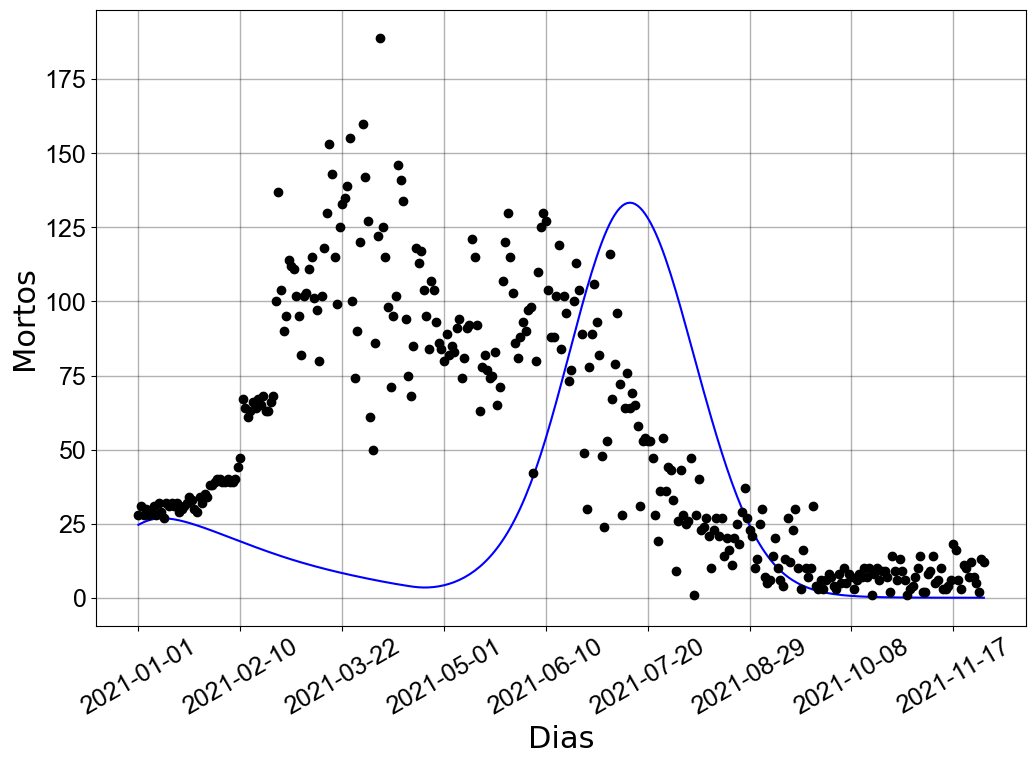

In [87]:

qi = qs[:,-3] #mortes acumulados

#Criando plot
fig, ax = pl.subplots(figsize=(12,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)

ax.scatter(datas[:len(np.diff(mortos_dados))],  np.diff(mortos_dados),color='black',zorder=3,label='Reported data')
#ax.vlines([126.48480189, 172.97799643, 288.57269974], 0, 200)
#Plot the fitted function as a line.
ax.plot(datas[:len(np.diff(N*qi))], np.diff(N*qi),color='blue',label='Fitted function')
ax.autoscale()

#Set the labels
ax.set_ylabel('Mortos',fontsize=22)
ax.set_xlabel('Dias', fontsize=22)
#Set the title
#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(pl.MaxNLocator(10))
#Rotating the dates for better visualization
pl.setp(ax.get_xticklabels(), rotation=30)


#Setting the font of the numbers on the axixis as ARIAL 
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")  

#Show Graph       
pl.show()


In [84]:
# best_pop    

In [85]:
(casos_dados[1]-casos_dados[0])/N
qs[:,-2][0]

0.03326039610936926

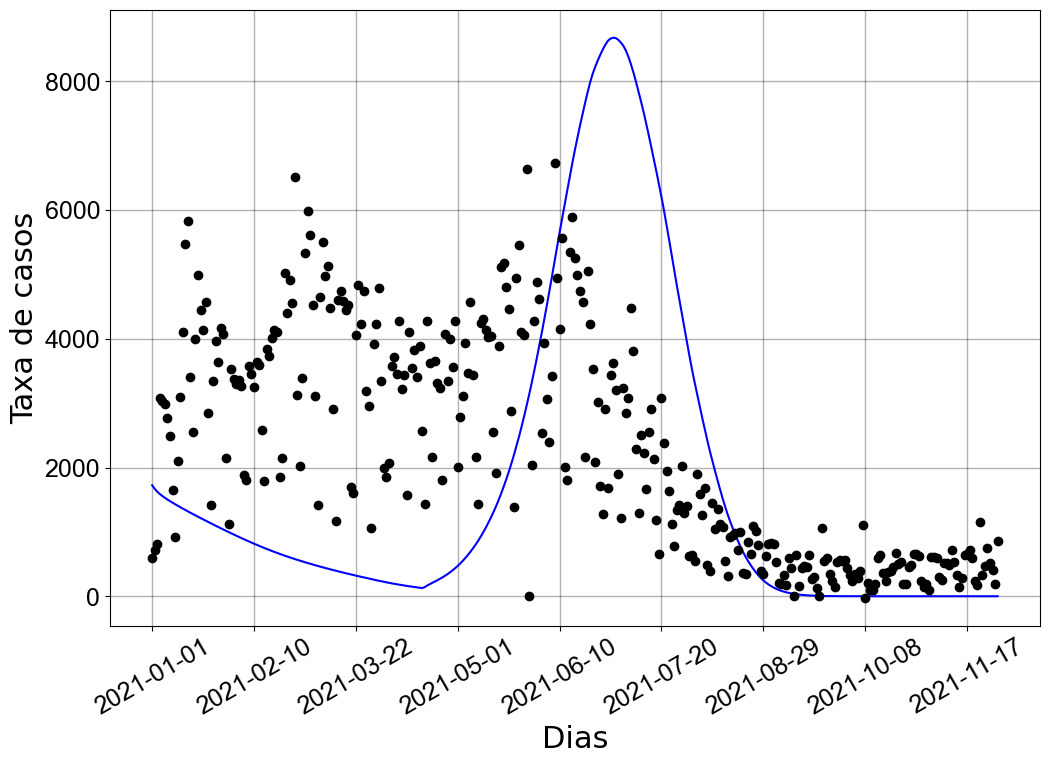

In [89]:

qi = qs[:,-2] #mortes acumulados

#Criando plot
fig, ax = pl.subplots(figsize=(12,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)

ax.scatter(datas[:len(np.diff(casos_dados))],  np.diff(casos_dados),color='black',zorder=3,label='Reported data')

#Plot the fitted function as a line.
ax.plot(datas[:len(np.diff(N*qi))], np.diff(N*qi),color='blue',label='Fitted function')
ax.autoscale()

#Set the labels
ax.set_ylabel('Taxa de casos',fontsize=22)
ax.set_xlabel('Dias', fontsize=22)
#Set the title
#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(pl.MaxNLocator(10))
#Rotating the dates for better visualization
pl.setp(ax.get_xticklabels(), rotation=30)


#Setting the font of the numbers on the axixis as ARIAL 
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")  

#Show Graph       
pl.show()
